#### 224 Resnet18 224 pixel image duration is 4 - with mixup and tta

* do mixup with multiple sounds to improve generalization
* modify samples - change pitch and timing.  add other sounds.  add noise.
* can we use the three channels for different signals?


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
import torch
from tqdm import tqdm_notebook
import librosa
import librosa.display

In [3]:
from fastai_audio import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
#import torchaudio
import pandas as pd
import numpy as np

In [5]:
bs = 160

In [6]:
path = Path("/media/SSD/Freesound Audio Tagging 2019")
train_curated_csv = path/'train_curated.csv'
train_noisy_csv = path/'train_noisy.csv'
sample_submission_csv = path/'sample_submission.csv'
train_curated = path/'train'
train_noisy = path/'train'
test = path/'test'

work = path/'work'
img_train_curated = work/'image/trn_curated'
#IMG_TRN_NOISY = work/'image/train_noisy'
img_test = work/'image/test'
for folder in [work, img_train_curated, img_test]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

train_df = pd.read_csv(train_curated_csv)
test_df = pd.read_csv(sample_submission_csv)
noisy_df = pd.read_csv(train_noisy_csv)

The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process:
f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav

So we will remove them.

In [8]:
train_df = train_df[~train_df.fname.isin(['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav'])]

In [9]:
import IPython.display  # To play sound in the notebook
fname = str(train_curated/'0019ef41.wav' )  # Raindrop
IPython.display.Audio(fname)

# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)


## convert audio to images
- use each of the 3 channels for a different scale
- use a filtering approach?
- use a hilbert transform for one of the channels?


In [10]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y


In [11]:
def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram



def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels



    

    
# example
#x = read_as_melspectrogram(conf, train_curated/'0006ae4e.wav', trim_long_data=False, debug_display=True)

In [12]:




def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V



def convert_wav_to_image(df, source):
    X = []
    #for i, row in tqdm_notebook(df.iterrows()):
    for i in progress_bar(df.index):
        x = read_as_melspectrogram(conf, source/str(df.loc[i].fname), trim_long_data=False)
        x_color = mono_to_color(x)
        
        X.append(x_color)
    return X



In [13]:
def parallel_melspectrogram(i):
   
    source=train_curated   
    
    x = read_as_melspectrogram(conf, source/str(df.loc[i].fname), trim_long_data=False)
    x_color = mono_to_color(x)
    
    return x_color


In [14]:
from joblib import Parallel, delayed
def convert_wav_to_image_parallel(df, source):
    
    X = Parallel(n_jobs=8)(delayed(parallel_melspectrogram)(i) for i in progress_bar(df.index))
    
    
    return X



In [16]:
#better block
def parallel_melspectrogram(i,df,source):
   
       
    
    x = read_as_melspectrogram(conf, source/str(df.loc[i].fname), trim_long_data=False)
    x_color = mono_to_color(x)
    
    return x_color

from joblib import Parallel, delayed
def convert_wav_to_image_parallel(df, source):
    #source=train_curated
    X = Parallel(n_jobs=8)(delayed(parallel_melspectrogram)(i,df,source) for i in progress_bar(df.index))
    
    
    return X

In [17]:
class conf:
    # Preprocessing settings for using 224 dim images
    sampling_rate = 44100
    duration = 4 
    #hop_length = 347*duration # to make time steps 128   
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 224
    n_fft = n_mels * 20
    samples = int(sampling_rate * duration)
    hop_length = n_fft//6

In [18]:
X_train = convert_wav_to_image_parallel(train_df, source=train_curated)
#X_test = convert_wav_to_image(test_df, source=test, img_dest=img_test)

/home/filip/anaconda3/envs/fastai/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
im = PIL.Image.fromarray(X_train[0])
print("time dim=",im.size[0], " base dim=",im.size[1])
im

In [ ]:
X_train[0].shape

## Custom open_image for fast.ai library to load data from memory

In [24]:
X_data= X_train
data_df = pd.concat([train_df], ignore_index=True, sort=False)

In [25]:
CUR_X_FILES, CUR_X = list(data_df.fname.values), X_data

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

## lwlrap metric

In [26]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])


In [27]:
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

In [28]:
class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            new_input = (last_input * lambd.view(lambd.size(0),1,1,1) + x1 * (1-lambd).view(lambd.size(0),1,1,1))
        if self.stack_y:
            new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class MixUpLoss(nn.Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) == 2:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            d = (loss1 * target[:,2] + loss2 * (1-target[:,2])).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

def mixup(learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add mixup https://arxiv.org/abs/1710.09412 to `learn`."
    learn.callback_fns.append(partial(MixUpCallback, alpha=alpha, stack_x=stack_x, stack_y=stack_y))
    return learn
Learner.mixup = mixup


In [29]:
learn=None
gc.collect()
torch.cuda.empty_cache()
np.random.seed(42)
tfms = get_transforms(do_flip=False, max_rotate=0, max_lighting=0.2, max_zoom=0, max_warp=0)
src = (ImageList.from_df(path=work/'image',df=train_df,folder=Path("../../img_train"))
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)
#data = (src.transform(tfms, size=224)
#        .databunch(bs=bs).normalize(imagenet_stats)
#)
data = (src.transform( tfms,size=224)
        .databunch(bs=bs)
)

In [30]:
#learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap]).to_fp16()
#learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
#learn = cnn_learner(data, models.resnet18, pretrained=True, metrics=[lwlrap])
#learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap]).to_fp16()
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=[lwlrap]).to_fp16()

In [31]:
learn.mixup(stack_y=False)
learn.freeze()

In [23]:
learn.fit_one_cycle(10,max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,lwlrap,time
0,0.797318,0.650656,0.107315,00:12
1,0.504721,0.074338,0.259133,00:08
2,0.290601,0.060953,0.369211,00:08
3,0.188636,0.052455,0.488594,00:08
4,0.134272,0.049300,0.528244,00:09
5,0.103038,0.046972,0.559906,00:08
6,0.084051,0.046546,0.565327,00:08
7,0.072546,0.044625,0.598117,00:08
8,0.065372,0.044361,0.598667,00:08
9,0.060668,0.044313,0.594496,00:08


In [24]:
    learn.save('res34-13-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


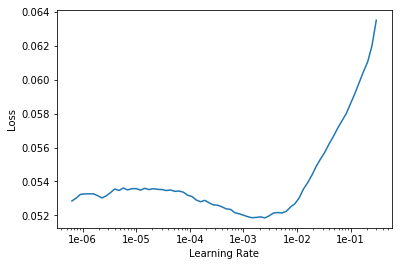

In [25]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(20,max_lr=slice(5e-4,1e-2))

epoch,train_loss,valid_loss,lwlrap,time
0,0.053212,0.041054,0.631312,00:11
1,0.049981,0.037620,0.677091,00:11
2,0.047560,0.042648,0.620798,00:11
3,0.046666,0.052451,0.515946,00:11
4,0.046592,0.044000,0.596073,00:11
5,0.045582,0.043271,0.598813,00:11
6,0.043983,0.042026,0.613771,00:11
7,0.042281,0.033151,0.690324,00:11
8,0.040649,0.034323,0.706503,00:11
9,0.039166,0.036029,0.673131,00:11


In [27]:
learn.save('res34-13-stage-2')

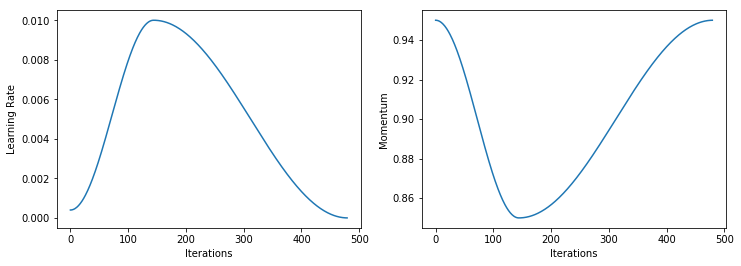

In [28]:
learn.recorder.plot_lr(show_moms=True)

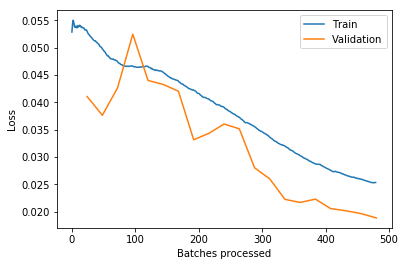

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.fit_one_cycle(20,max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,lwlrap,time
0,0.025448,0.019908,0.839951,00:11
1,0.025115,0.020376,0.837275,00:11
2,0.024976,0.021242,0.825657,00:11
3,0.025444,0.024578,0.799921,00:11
4,0.026347,0.025228,0.791063,00:11
5,0.027489,0.026808,0.774733,00:11
6,0.027834,0.027542,0.777239,00:11
7,0.027671,0.029110,0.757662,00:11
8,0.027253,0.023985,0.803508,00:11
9,0.026540,0.026108,0.785386,00:11


In [31]:
learn.save('res34-13-stage-3')

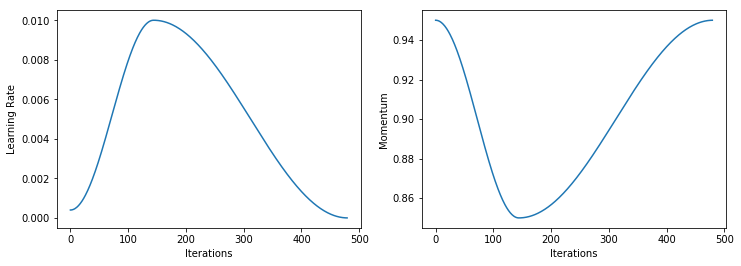

In [32]:
learn.recorder.plot_lr(show_moms=True)

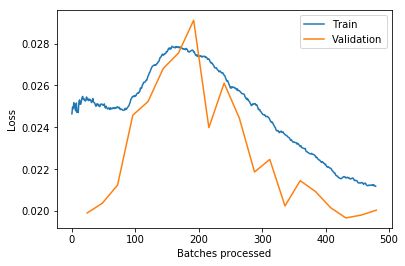

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.fit_one_cycle(20,max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,lwlrap,time
0,0.021646,0.020714,0.839401,00:10
1,0.021274,0.020728,0.840163,00:10
2,0.021223,0.020288,0.839932,00:11
3,0.021395,0.021651,0.834490,00:11
4,0.021299,0.021468,0.829377,00:10
5,0.021681,0.020994,0.833330,00:11
6,0.021620,0.020337,0.839182,00:11
7,0.021477,0.021632,0.839335,00:11
8,0.021439,0.021113,0.836622,00:10
9,0.021238,0.021702,0.823682,00:11


In [35]:
learn.save('res34-13-stage-4')

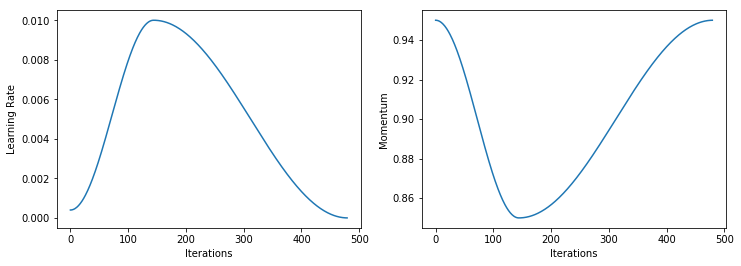

In [36]:
learn.recorder.plot_lr(show_moms=True)

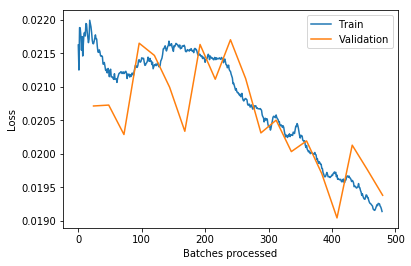

In [37]:
learn.recorder.plot_losses()

In [ ]:
data.show_batch(3)


## Interpret

In [32]:

learn.load('res34-13-stage-4')
learn.to_fp32()
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
samples=20
figsize=(8,8)
    
#losses, idxs = self.top_losses(self.data.c)
l_dim = len(losses.size())
if l_dim == 1: losses, idxs = interp.top_losses()
infolist, ordlosses_idxs, mismatches_idxs, mismatches, losses_mismatches, mismatchescontainer = [],[],[],[],[],[]
truthlabels = np.asarray(interp.y_true, dtype=int)
classes_ids = [k for k in enumerate(interp.data.classes)]
predclass = np.asarray(interp.pred_class)
for i,pred in enumerate(predclass):
    where_truth = np.nonzero((truthlabels[i]>0))[0]
    mismatch = np.all(pred!=where_truth)
    if mismatch:
        mismatches_idxs.append(i)
        if l_dim > 1 : losses_mismatches.append((losses[i][pred], i))
        else: losses_mismatches.append((losses[i], i))
    if l_dim > 1: infotup = (i, pred, where_truth, losses[i][pred], np.round(interp.probs[i], decimals=3)[pred], mismatch)
    else: infotup = (i, pred, where_truth, losses[i], np.round(interp.probs[i], decimals=3)[pred], mismatch)
    infolist.append(infotup)
ds = interp.data.dl(interp.ds_type).dataset
mismatches = ds[mismatches_idxs]
ordlosses = sorted(losses_mismatches, key = lambda x: x[0], reverse=True)
for w in ordlosses: ordlosses_idxs.append(w[1])
mismatches_ordered_byloss = ds[ordlosses_idxs]
print(f'{str(len(mismatches))} misclassified samples over {str(len(interp.data.valid_ds))} samples in the validation set.')
samples = min(samples, len(mismatches))
for ima in range(len(mismatches_ordered_byloss)):
    mismatchescontainer.append(mismatches_ordered_byloss[ima][0])
    
poor_classes=[]
p_i=0
for sampleN in range(samples):
    actualclasses = ''
    for clas in infolist[ordlosses_idxs[sampleN]][2]:
        actualclasses = f'{actualclasses} -- {str(classes_ids[clas][1])}'
        poor_classes= poor_classes + [str(classes_ids[clas][1])]
        
    
    poor_classes= poor_classes + [str(classes_ids[infolist[ordlosses_idxs[sampleN]][1]][1])]
    
    
    #imag = mismatches_ordered_byloss[sampleN][0]
    #imag = show_image(imag, figsize=figsize)
    #imag.set_title(f"""Predicted: {classes_ids[infolist[ordlosses_idxs[sampleN]][1]][1]} \nActual: {actualclasses}\nLoss: {infolist[ordlosses_idxs[sampleN]][3]}\nProbability: {infolist[ordlosses_idxs[sampleN]][4]}""",
    #                loc='left')
    plt.show()

    print(f"""Predicted: {classes_ids[infolist[ordlosses_idxs[sampleN]][1]][1]} Actual: {actualclasses}Loss: {infolist[ordlosses_idxs[sampleN]][3]} Probability: {infolist[ordlosses_idxs[sampleN]][4]}""")

poor_classes=list(set(poor_classes))
    
    
print(poor_classes)


196 misclassified samples over 993 samples in the validation set.
Predicted: Strum Actual:  -- GongLoss: 7.738807678222656 Probability: 0.546999990940094
Predicted: Scissors Actual:  -- BuzzLoss: 7.421661376953125 Probability: 0.5839999914169312
Predicted: Whispering Actual:  -- Electric_guitarLoss: 7.406545639038086 Probability: 0.13500000536441803
Predicted: Bathtub_(filling_or_washing) Actual:  -- Sink_(filling_or_washing) -- Water_tap_and_faucetLoss: 7.3938727378845215 Probability: 0.5230000019073486
Predicted: Traffic_noise_and_roadway_noise Actual:  -- Accelerating_and_revving_and_vroomLoss: 7.179053783416748 Probability: 0.4129999876022339
Predicted: Yell Actual:  -- Dishes_and_pots_and_pans -- Squeak -- Trickle_and_dribbleLoss: 7.130629539489746 Probability: 0.1550000011920929
Predicted: Frying_(food) Actual:  -- Sink_(filling_or_washing) -- Water_tap_and_faucetLoss: 6.927591800689697 Probability: 0.7919999957084656
Predicted: Clapping Actual:  -- ScissorsLoss: 6.13119029998779

In [33]:
df = noisy_df.copy()
df['singled'] = ~df.labels.str.contains(',')
singles_df = df[df.singled]


In [34]:
singles_df[singles_df.labels==poor_classes[1]]

,fname,labels,singled
129,017c8dd1.wav,Electric_guitar,True
225,02b59327.wav,Electric_guitar,True
383,04c1d7e9.wav,Electric_guitar,True
498,0662c71f.wav,Electric_guitar,True
560,07753843.wav,Electric_guitar,True
581,07ad6e46.wav,Electric_guitar,True
806,0a883fd0.wav,Electric_guitar,True
1205,0f696e98.wav,Electric_guitar,True
1322,10e0e965.wav,Electric_guitar,True
1778,16c04cce.wav,Electric_guitar,True


In [35]:
train_addition_df= pd.DataFrame(columns=singles_df.columns)
for p in poor_classes:
    #print(p)
    #print(singles_df[singles_df.labels == p])
    train_addition_df = pd.concat([train_addition_df, singles_df[singles_df.labels == p]])

In [36]:
train_addition_df

,fname,labels,singled
100,012293ea.wav,Trickle_and_dribble,True
134,01a21197.wav,Trickle_and_dribble,True
190,02319a7d.wav,Trickle_and_dribble,True
266,032f9c3d.wav,Trickle_and_dribble,True
269,0347ad96.wav,Trickle_and_dribble,True
322,03f57250.wav,Trickle_and_dribble,True
341,0431784d.wav,Trickle_and_dribble,True
361,0469b44a.wav,Trickle_and_dribble,True
502,066905fa.wav,Trickle_and_dribble,True
732,0974e616.wav,Trickle_and_dribble,True


In [37]:
X_train2 = convert_wav_to_image_parallel(train_addition_df, source=train_noisy)
#X_test = convert_wav_to_image(test_df, source=test, img_dest=img_test)

## Custom open_image for fast.ai library to load data from memory

In [45]:

data_df = pd.concat([train_df,train_addition_df], ignore_index=True, sort=False)

In [46]:
CUR_X_FILES, CUR_X = list(data_df.fname.values), (X_train + X_train2)
#CUR_X_FILES, CUR_X = list(train_addition_df.fname.values), (X_train2)
def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    #print(fn)
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

In [47]:
learn=None
gc.collect()
torch.cuda.empty_cache()
np.random.seed(42)
tfms = get_transforms(do_flip=False, max_rotate=0, max_lighting=0.2, max_zoom=0, max_warp=0)
src = (ImageList.from_df(path=work/'image',df=data_df,folder=Path("../../img_train"))
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)
#data = (src.transform(tfms, size=224)
#        .databunch(bs=bs).normalize(imagenet_stats)
#)
data = (src.transform( tfms,size=224)
        .databunch(bs=bs)
)

In [48]:
#learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap]).to_fp16()
#learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
#learn = cnn_learner(data, models.resnet18, pretrained=True, metrics=[lwlrap])
#learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap]).to_fp16()
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=[lwlrap]).to_fp16()

In [49]:
learn.mixup(stack_y=False)
learn.load('res34-13-stage-4')
learn.unfreeze()

In [50]:
learn.fit_one_cycle(20,max_lr=slice(5e-4,1e-2))

epoch,train_loss,valid_loss,lwlrap,time
0,0.042430,0.025959,0.748684,00:37
1,0.037710,0.024083,0.763824,00:34
2,0.035992,0.027539,0.732535,00:28
3,0.036461,0.033971,0.650479,00:28
4,0.037589,0.047233,0.555161,00:28
5,0.037989,0.039550,0.585066,00:28
6,0.037140,0.041928,0.565537,00:28
7,0.036052,0.034397,0.657942,00:29
8,0.034999,0.033618,0.663622,00:28
9,0.033633,0.031403,0.683490,00:28


In [51]:
    learn.save('res34-13-stage-5')

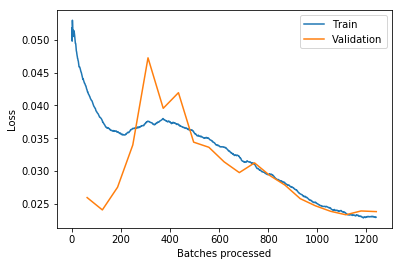

In [52]:
learn.recorder.plot_losses()

In [61]:
learn.to_fp16()
learn.fit_one_cycle(20,max_lr=slice(5e-5,1e-2))

epoch,train_loss,valid_loss,lwlrap,time
0,0.019583,0.026519,0.769657,00:28
1,0.019414,0.026493,0.771594,00:28
2,0.019562,0.027086,0.762403,00:28
3,0.019881,0.027326,0.769455,00:28
4,0.020182,0.029954,0.747494,00:28
5,0.020516,0.030004,0.744496,00:28
6,0.020826,0.032634,0.738729,00:29
7,0.020618,0.028724,0.756137,00:29
8,0.020853,0.028539,0.759491,00:28
9,0.020396,0.028458,0.756166,00:29


In [62]:
learn.save('res34-13-stage-6')

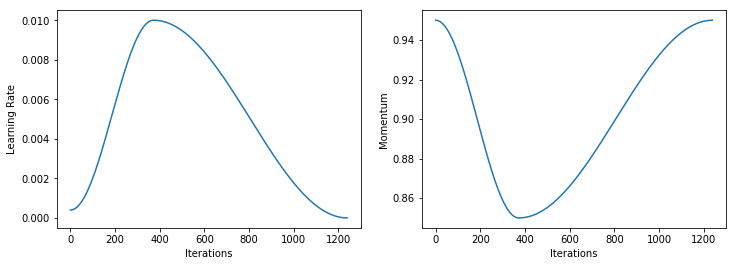

In [63]:
learn.recorder.plot_lr(show_moms=True)

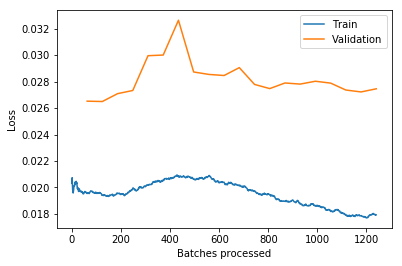

In [64]:
learn.recorder.plot_losses()

In [65]:
learn.load('res34-13-stage-6')
learn.to_fp32()
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

False

In [66]:
print(str(learn.metrics))
learn.validate()

[0.027412137, tensor(0.7692)]

831 misclassified samples over 2482 samples in the validation set.


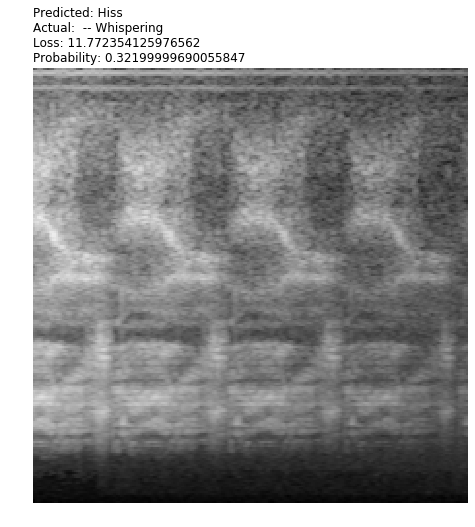

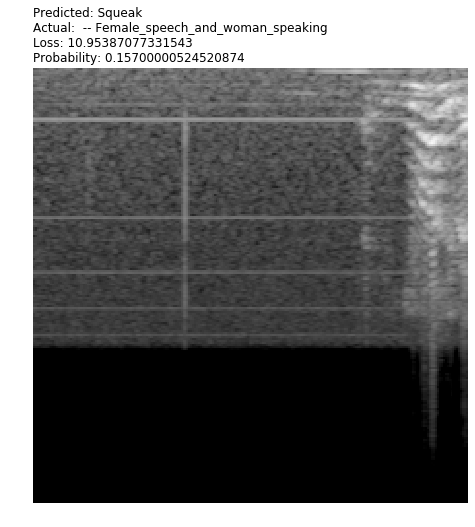

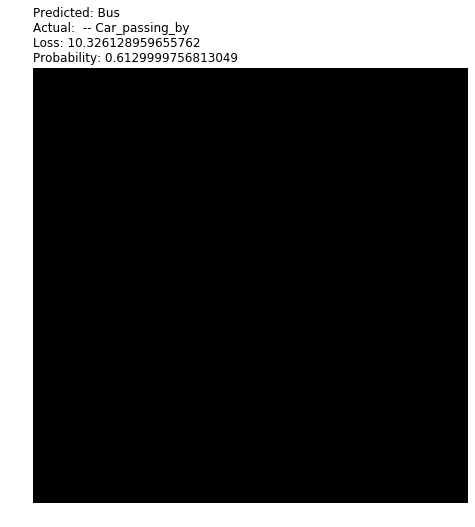

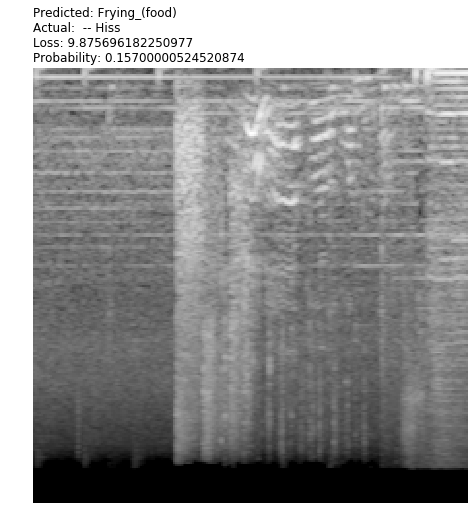

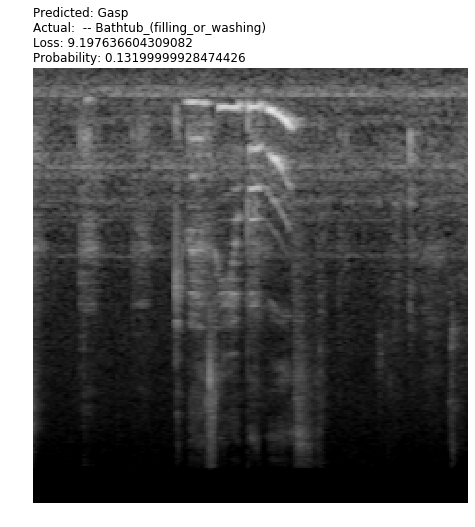

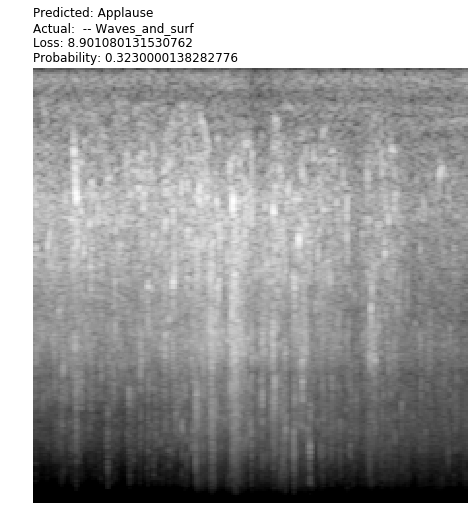

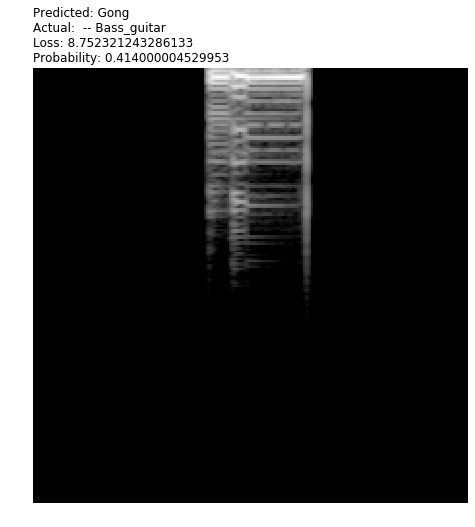

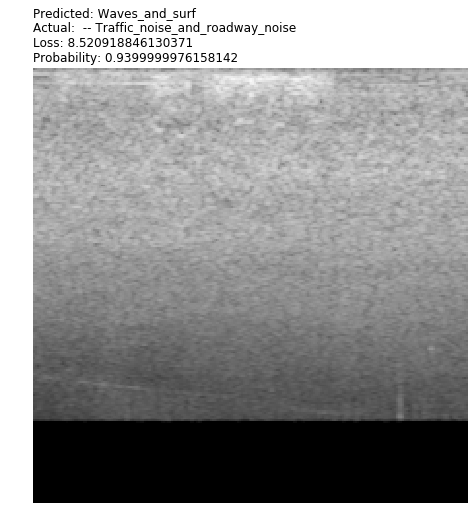

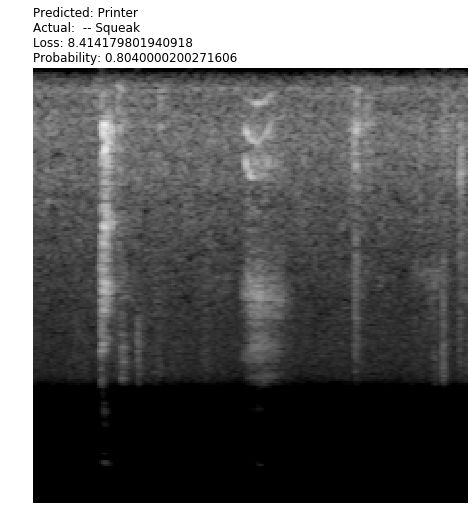

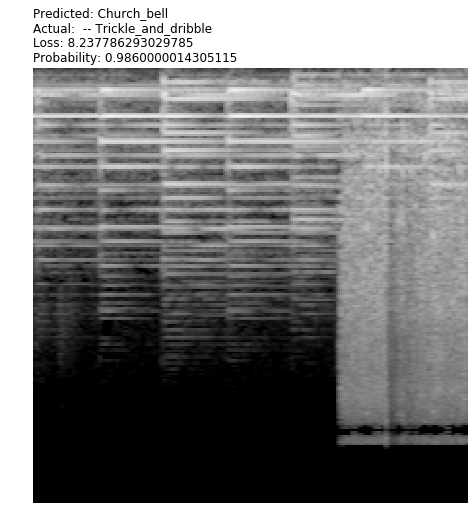

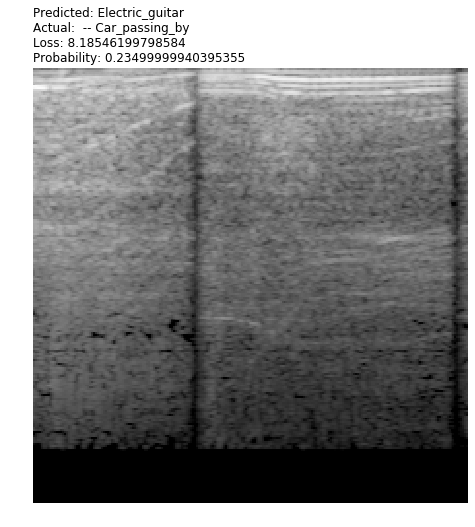

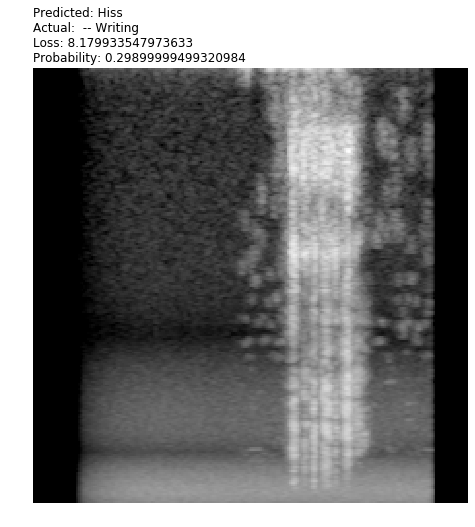

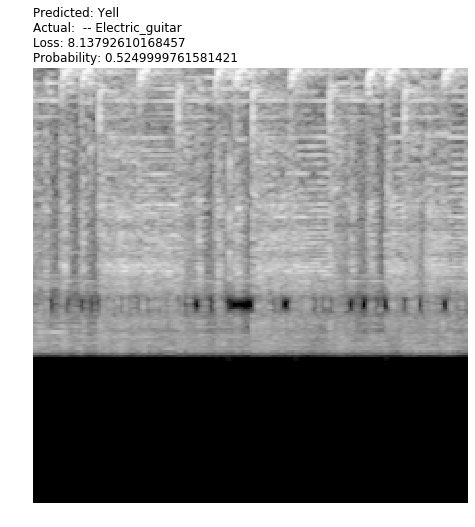

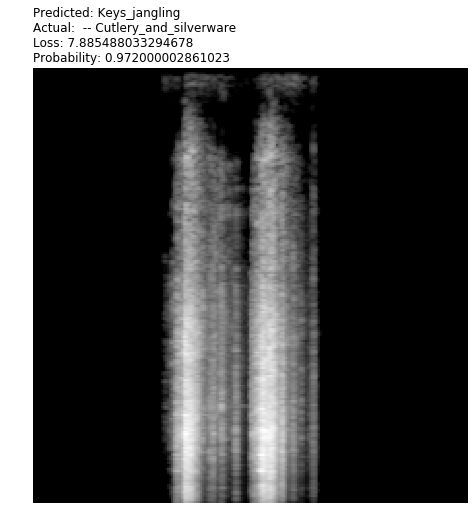

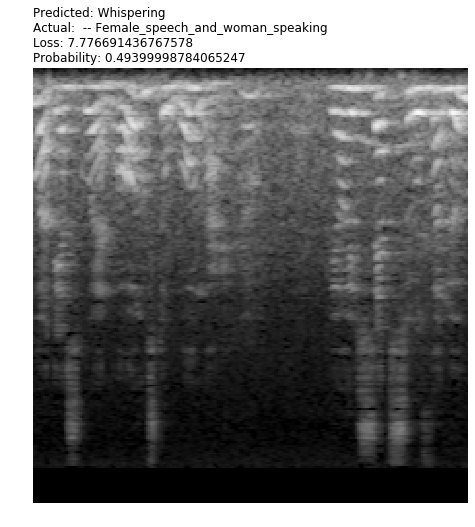

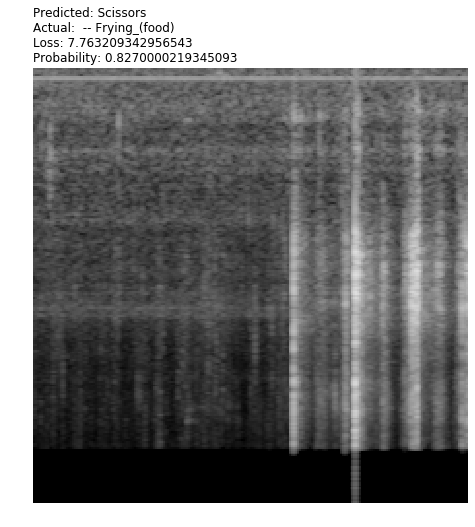

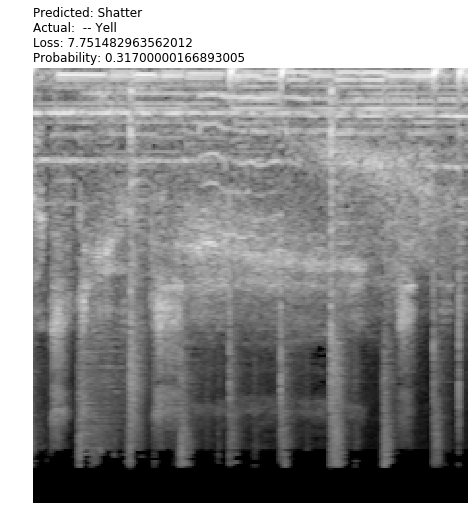

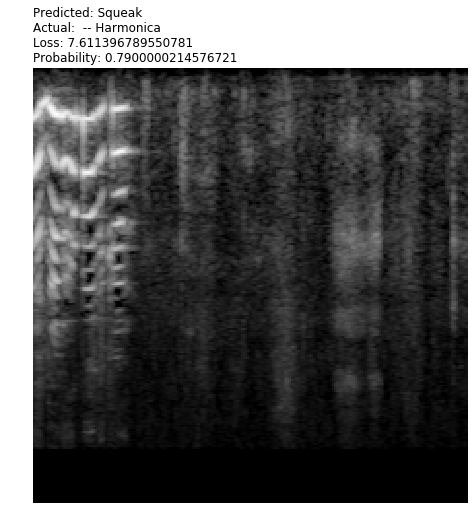

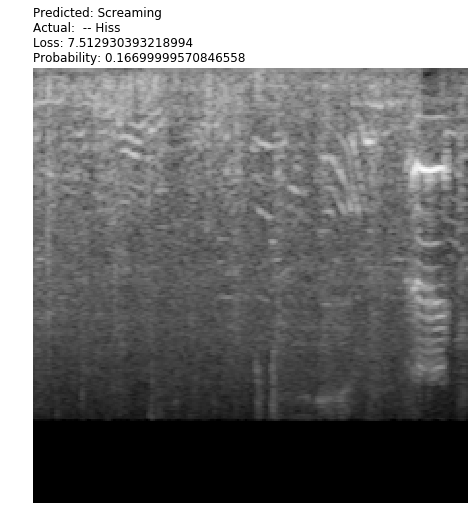

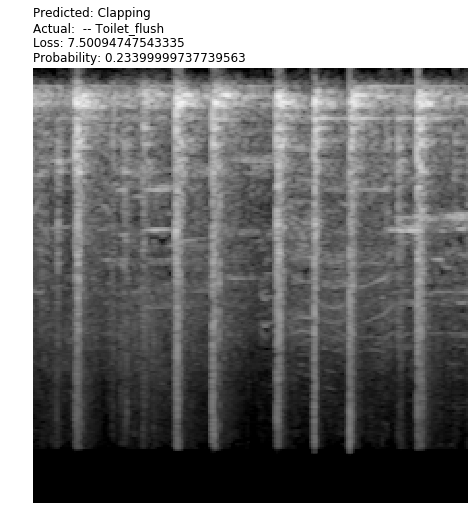

In [67]:
interp.plot_multi_top_losses(20)
